In [7]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
import cv2
import os 
import numpy as np
import pathlib


In [8]:
data_dir = r"C:\Users\sulan\OneDrive\Desktop\Rice Type Classification\archive\Rice_Image_Dataset"
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/sulan/OneDrive/Desktop/Rice Type Classification/archive/Rice_Image_Dataset')

In [9]:
arborio = list(data_dir.glob('Arborio/*')) [:600]
basmati = list(data_dir.glob('Basmati/*')) [:600]
ipsala = list(data_dir.glob('Ipsala/*')) [:600]
jasmine = list(data_dir.glob('Jasmine/*')) [:600]
karacadag = list(data_dir.glob('Karacadag/*')) [:600]

In [10]:
img = cv2.imread(str(arborio[0]))# Converting it into numerical arrays 
img.shape # Its currently 250 by 250 by 3

(250, 250, 3)

In [11]:
df_images = {
    'arborio': arborio,
    'basmati': basmati,
    'ipsala': ipsala,
    'jasmine': jasmine,
    'karacadag': karacadag,
}
#Contains numerical labels for the categories
df_labels = {
    'arborio': 0,
    'basmati': 1,
    'ipsala': 2,
    'jasmine': 3,
    'karacadag': 4
}

In [12]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) #
        X.append(resized_img)
        y.append(df_labels [label])

In [13]:

X = np.array(X, dtype=np.float32) / 255.0  # Normalize and use float32
y = np.array(y)


In [14]:
X_train, X_test_val, y_train, y_test_val=train_test_split(X, y)
X_test, X_val, y_test, y_val=train_test_split(X_test_val, y_test_val)

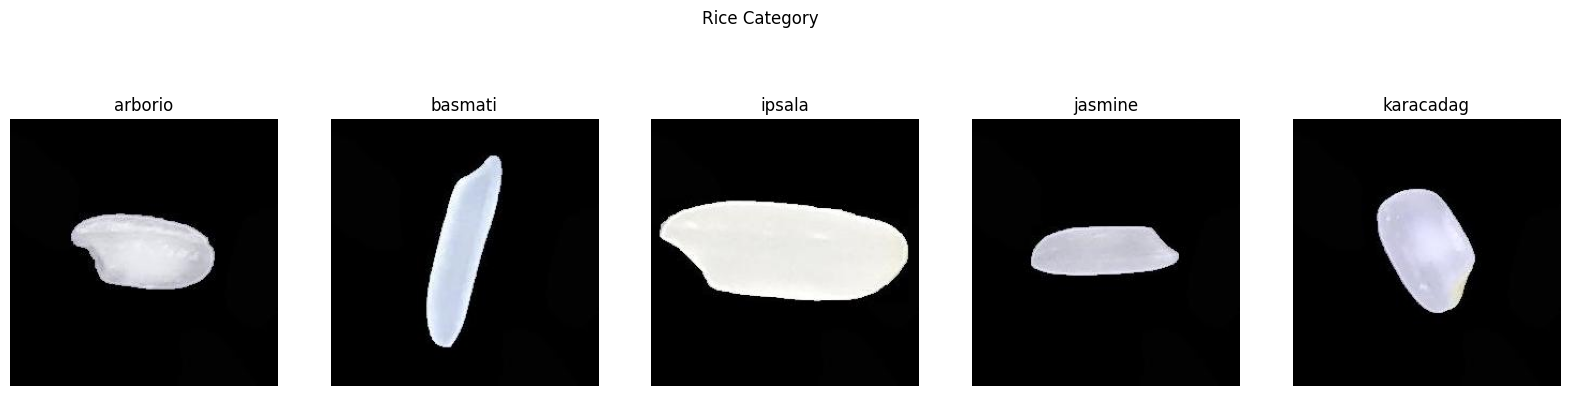

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  # Use a distinct alias
# assume arborio, basmati, etc. are already defined
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
fig.suptitle('Rice Category')

# Use mpimg instead of img to avoid conflict
arborio_image = mpimg.imread(arborio[0])
basmati_image = mpimg.imread(basmati[0])
ipsala_image = mpimg.imread(ipsala[0])
jasmine_image = mpimg.imread(jasmine[0])
karacadag_image = mpimg.imread(karacadag[0])

# Set titles
ax[0].set_title('arborio')
ax[1].set_title('basmati')
ax[2].set_title('ipsala')
ax[3].set_title('jasmine')
ax[4].set_title('karacadag')

# Show images
ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)
for a in ax:
    a.axis('off')  # Turn off axes

plt.show()

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda

num_label = 5

mobile_net_hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
)

model = Sequential([
    Lambda(lambda x: mobile_net_hub_layer(x), name='mobilenet_wrapper'),
    Dense(num_label)
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_wrapper (Lambda)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7999 - loss: 0.5373 - val_accuracy: 0.9628 - val_loss: 0.0839
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 933ms/step - accuracy: 0.9780 - loss: 0.0835 - val_accuracy: 0.9628 - val_loss: 0.0612
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 68s 955ms/step - accuracy: 0.9878 - loss: 0.0452 - val_accuracy: 0.9787 - val_loss: 0.0589
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 926ms/step - accuracy: 0.9885 - loss: 0.0409 - val_accuracy: 0.9840 - val_loss: 0.0465
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 935ms/step - accuracy: 0.9922 - loss: 0.0368 - val_accuracy: 0.9840 - val_loss: 0.0333
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 70s 983ms/step - accuracy: 0.9954 - loss: 0.0242 - val_accuracy: 0.9947 - val_loss: 0.0286
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 70s 984ms/step - accuracy: 0.9979 - loss: 0.0136 - val_accuracy: 0.9894 - val_loss: 0.0350
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 66s 927ms/step - accuracy: 0.9964 - loss: 0.0191 - val_accurac

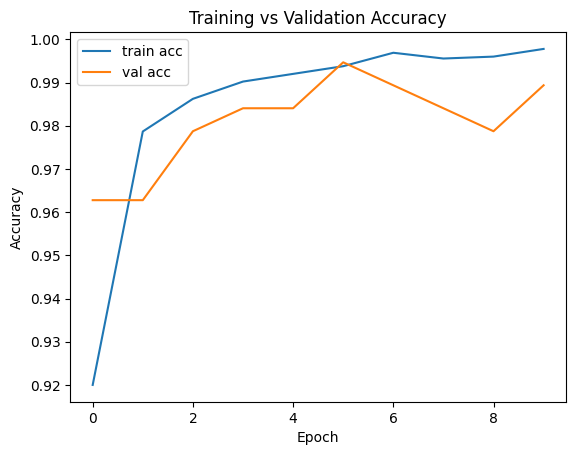

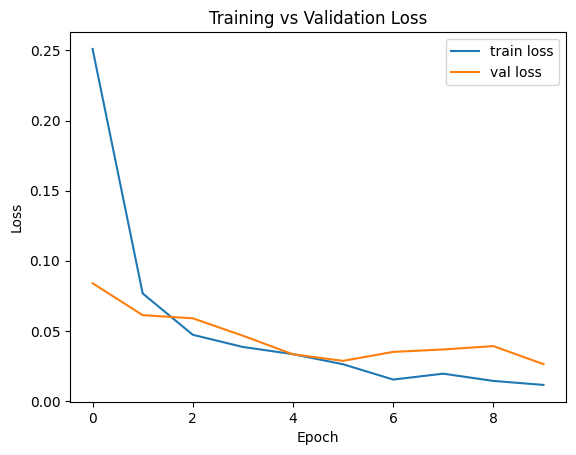

In [19]:
#visualizing the training
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [20]:
model.evaluate(X_test,y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 846ms/step - accuracy: 0.9915 - loss: 0.0298


[0.03265757858753204, 0.9911032319068909]

In [21]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))

9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       121
           1       0.99      0.99      0.99       100
           2       1.00      1.00      1.00       103
           3       0.99      0.99      0.99       120
           4       0.98      0.99      0.99       118

    accuracy                           0.99       562
   macro avg       0.99      0.99      0.99       562
weighted avg       0.99      0.99      0.99       562



In [33]:
import pandas as pd
import plotly.express as px

# Convert training history to DataFrame
acc_df = pd.DataFrame({
    'train_accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy']
})

# Plot accuracy
fig = px.line(
    acc_df,
    x=acc_df.index,
    y=acc_df.columns,
    title='Training and Validation Accuracy per Epoch',
    markers=True
)
fig.show()



In [34]:
loss_df = pd.DataFrame({
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})

fig = px.line(
    loss_df,
    x=loss_df.index,
    y=loss_df.columns,
    title='Training and Validation Loss per Epoch',
    markers=True
)
fig.show()

In [51]:
a1 = cv2.imread(r"C:\Users\sulan\OneDrive\Desktop\Rice Type Classification\archive\Rice_Image_Dataset\Arborio\Arborio (8).jpg")
a1 = cv2.resize(a1, (224, 224))   # Resize to match model input
a1 = np.array(a1) / 255           # Normalize pixel values
a1 = np.expand_dims(a1, 0)        # Add batch dimension (1, 224, 224, 3)
pred = model.predict(a1)          # Get prediction
pred = pred.argmax()              # Get predicted class index

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


In [52]:
for i, j in df_labels.items():
    if pred == j:
        print(i) 


arborio


In [54]:
model.save("rice_model.keras")

18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 814ms/step


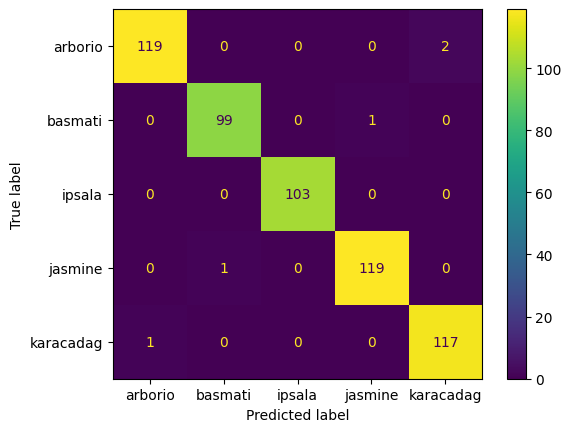

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_labels.keys())
disp.plot()
